### **Querie 1: What are the top 5 most popular Middle Schools and how many admitted students did each send?**

In [1]:
!pip install pandas reportlab matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.0 MB/s eta 0:00:00


In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from PIL import Image
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
conn = sqlite3.connect('School.db')
cursor = conn.cursor()

In [4]:
conn.text_factory = lambda b: b.decode('utf-8', 'replace')

In [5]:
query_1 = """
SELECT Sending_ms.ms_name, COUNT(DISTINCT Admission.admission_id) AS admitted_students_count
FROM Sending_ms
JOIN Admission ON Sending_ms.sending_ms_id = Admission.sending_ms_id
JOIN College ON Admission.admission_id = College.admission_id
JOIN Students ON College.college_id = Students.college_id
JOIN Applications ON Students.student_id = Applications.student_id
WHERE Applications.admitted = 1
GROUP BY Sending_ms.ms_name
ORDER BY admitted_students_count DESC
LIMIT 5;
"""

In [6]:
df = pd.read_sql_query(query_1, conn)
df.head()

,ms_name,admitted_students_count
0,Monsignor James J. Haddad Middle School,222
1,St. Clement,23
2,St. Mark�s School,22
3,St. John's High School,21
4,Cyril Brennan Middle School,14


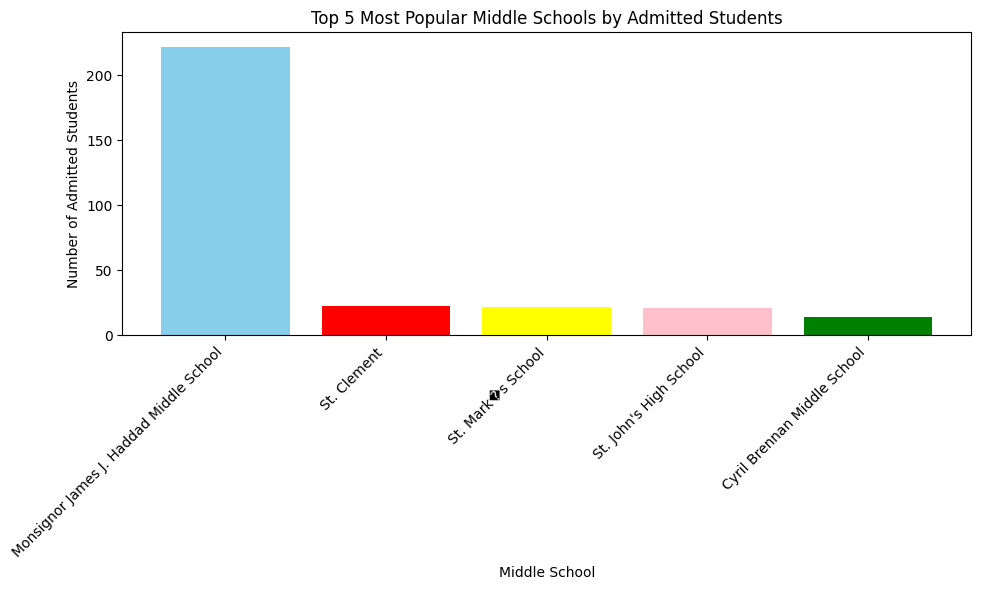

In [7]:
# Plotting the results
fig, axs  = plt.subplots(figsize=(10, 6))

plt.bar(df['ms_name'], df['admitted_students_count'], color=['skyblue', 'red', 'yellow', 'pink', 'green'])
plt.xlabel('Middle School')
plt.ylabel('Number of Admitted Students')
plt.title('Top 5 Most Popular Middle Schools by Admitted Students')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


fig.canvas.draw()
buf = fig.canvas.tostring_rgb()
width, height = fig.canvas.get_width_height()
pil_image = Image.frombytes("RGB", (width, height), buf)

plt.show()

In [8]:
# Saving results as pdf
pdf_filename = " 1) Top_schools_report.pdf"
c = canvas.Canvas(pdf_filename, pagesize=letter)
c.setFont("Helvetica-Bold", 16)
c.drawString(100, 750, "Top 5 Most Popular Middle Schools and Admitted Students Count")
c.setFont("Helvetica", 12)
y_position = 730
for index, row in df.iterrows():
    text = f"{row['ms_name']} - {row['admitted_students_count']} admitted students"
    c.drawString(100, y_position, text)
    y_position -= 20
c.drawInlineImage(pil_image, x = 0, y = 300, width=width/1.75, height=height/1.75)
c.save()
files.download(pdf_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Query 2 : What is the ethnicity breakdown of each graduating class?**
### **Create a visualization comparing the ethnicity breakdowns between class of 2022 vs. class of 2019**

In [9]:
query_2 = """ SELECT
    Admission.grad_year,
    Admission.ethnicity,
    COUNT(Students.student_id) AS student_count
FROM
    Students
INNER JOIN
    Admission
ON
    Students.admission_id = Admission.admission_id
GROUP BY
    Admission.grad_year, Admission.ethnicity
ORDER BY
    Admission.grad_year, Admission.ethnicity;
"""
df_2 = pd.read_sql_query(query_2, conn)
df_2.head(10)

,grad_year,ethnicity,student_count
0,2019,African American,10
1,2019,Asian American,9
2,2019,European American (Caucasian),100
3,2019,Latino/Hispanic American,5
4,2019,Middle Eastern American,1
5,2019,Multiracial American,13
6,2020,African American,5
7,2020,Asian American,15
8,2020,European American (Caucasian),87
9,2020,Latino/Hispanic American,9


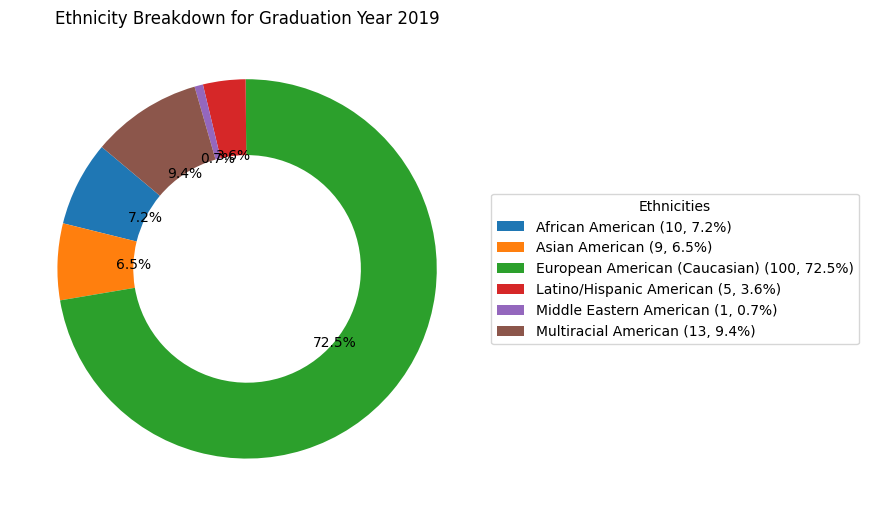

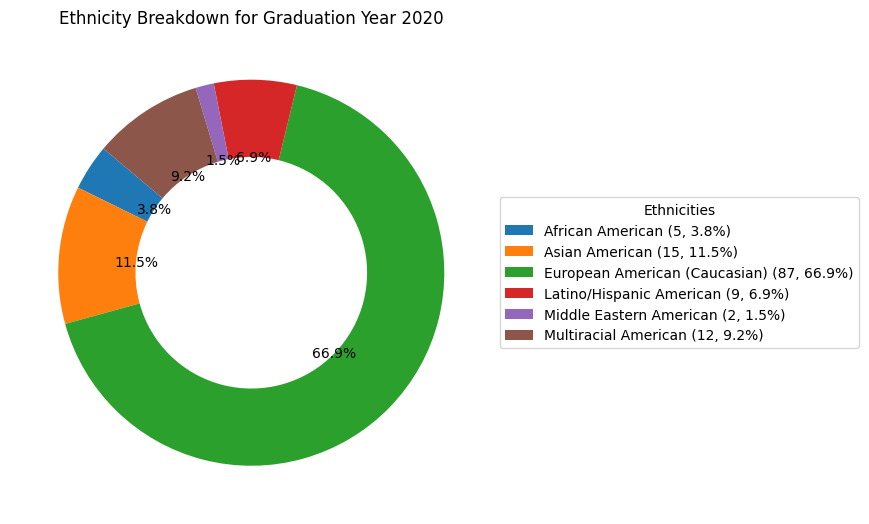

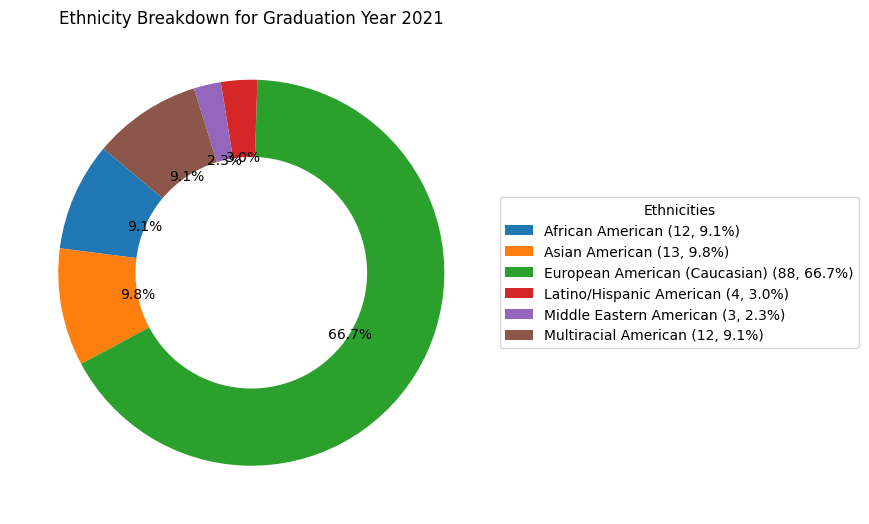

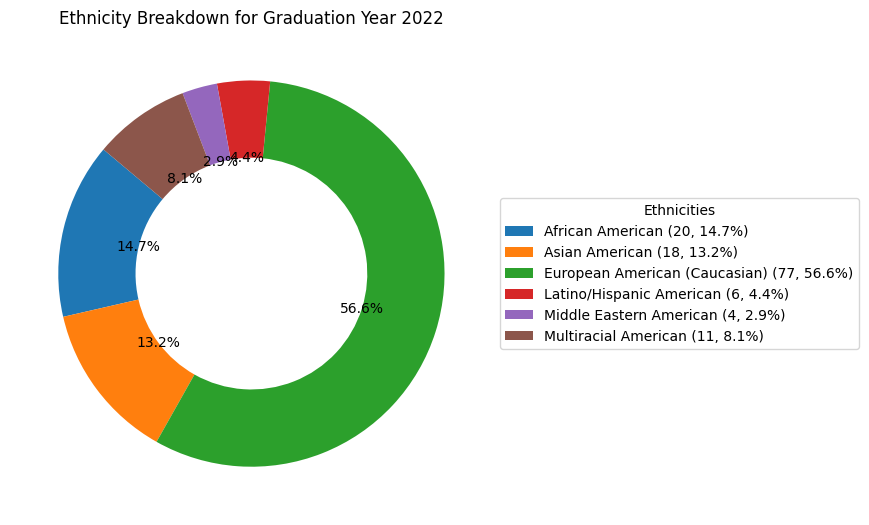

In [10]:
#Pie chart
graduation_years = df_2['grad_year'].unique()

for year in graduation_years:
    data = df_2[df_2['grad_year'] == year]

    labels = data['ethnicity']
    sizes = data['student_count']
    total = sizes.sum()


    plt.figure(figsize=(8, 6))
    wedges, _, autotexts = plt.pie(
        sizes,
        autopct=lambda p: f'{p:.1f}%' if p > 0 else '',
        startangle=140,
        wedgeprops=dict(width=0.4)  #
    )


    plt.legend(
        wedges,
        [f"{label} ({count}, {count/total:.1%})" for label, count in zip(labels, sizes)],
        title="Ethnicities",
        loc="center left",
        bbox_to_anchor=(1, 0, 0.5, 1)
    )


    plt.title(f"Ethnicity Breakdown for Graduation Year {year}")


    plt.tight_layout()
    plt.savefig(f"ethnicity_breakdown_{year}.png", dpi=300)
    plt.show()

In [11]:
#Report
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
import os
from PIL import Image


plot_dir = "/content/plots/"
os.makedirs(plot_dir, exist_ok=True)

for year in graduation_years:
    data = df_2[df_2['grad_year'] == year]
    labels = data['ethnicity']
    sizes = data['student_count']
    total = sizes.sum()

    plot_path = os.path.join(plot_dir, f"ethnicity_breakdown_{year}.png")
    plt.figure(figsize=(8, 6))
    wedges, _, autotexts = plt.pie(
        sizes,
        autopct=lambda p: f'{p:.1f}%' if p > 0 else '',
        startangle=140,
        wedgeprops=dict(width=0.4)
    )
    plt.legend(
        wedges,
        [f"{label} ({count}, {count/total:.1%})" for label, count in zip(labels, sizes)],
        title="Ethnicities",
        loc="center left",
        bbox_to_anchor=(1, 0, 0.5, 1)
    )
    plt.title(f"Ethnicity Breakdown for Graduation Year {year}")
    plt.tight_layout()
    plt.savefig(plot_path, dpi=300)
    plt.close()


pdf_filename = "Ethnicity_Breakdown_Report.pdf"
c = canvas.Canvas(pdf_filename, pagesize=letter)


c.setFont("Helvetica-Bold", 16)
c.drawString(50, 750, "Ethnicity Breakdown Report")


c.setFont("Helvetica", 12)
c.drawString(50, 730, "This report shows the ethnicity breakdown for each graduating class.")


y_position = 650
for year in graduation_years:
    plot_path = os.path.join(plot_dir, f"ethnicity_breakdown_{year}.png")
    if os.path.exists(plot_path):
        img = Image.open(plot_path)
        img_width, img_height = img.size
        scale = 400 / img_width
        scaled_width = int(img_width * scale)
        scaled_height = int(img_height * scale)

        if y_position - scaled_height < 100:
            c.showPage()
            c.setFont("Helvetica", 12)
            y_position = 750

        c.drawImage(plot_path, 50, y_position - scaled_height, width=scaled_width, height=scaled_height)
        c.setFont("Helvetica-Bold", 12)
        c.drawString(50, y_position, f"Graduation Year {year}")
        y_position -= (scaled_height + 30)


c.save()


try:
    from google.colab import files
    files.download(pdf_filename)
except ImportError:
    print(f"PDF saved as {pdf_filename}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
query_2a = """
SELECT grad_year, ethnicity, COUNT(*) AS count FROM Admission
WHERE grad_year IN (2022,2019)
GROUP BY grad_year, ethnicity
ORDER BY grad_year, count DESC;
"""

In [ ]:
df_2a = pd.read_sql_query(query_2a,conn)
df_2a.head(10)

,grad_year,ethnicity,count
0,2019,European American (Caucasian),104
1,2019,Multiracial American,13
2,2019,African American,10
3,2019,Asian American,9
4,2019,Latino/Hispanic American,6
5,2019,Middle Eastern American,1
6,2022,European American (Caucasian),82
7,2022,African American,22
8,2022,Asian American,18
9,2022,Multiracial American,12


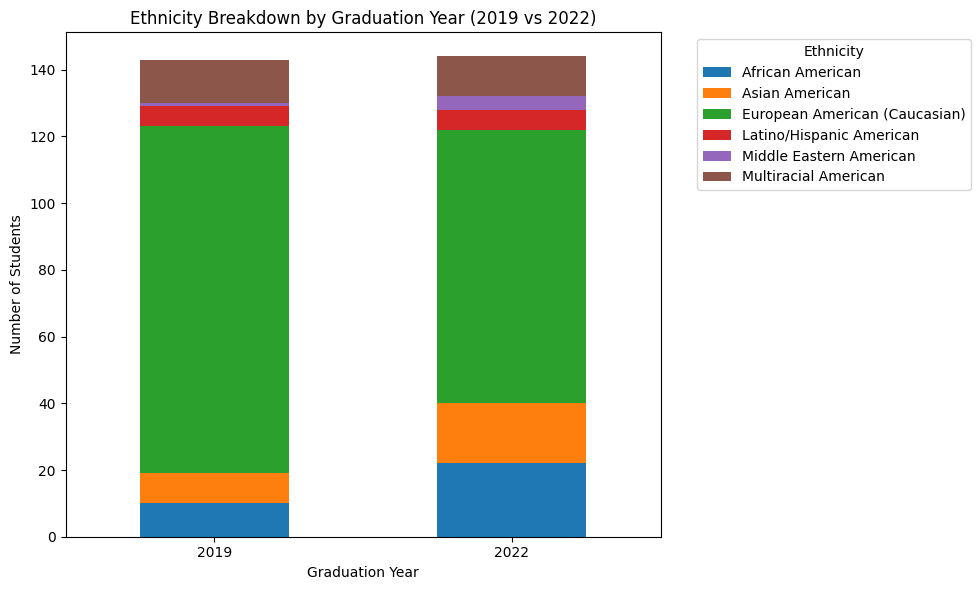

In [ ]:
# Plot
df_pivot = df_2a.pivot(index='grad_year', columns='ethnicity', values='count').fillna(0)

# Stack bar graphs
fig, ax = plt.subplots(figsize=(10, 6))
df_pivot.plot(kind='bar', stacked=True, ax = ax)

plt.title('Ethnicity Breakdown by Graduation Year (2019 vs 2022)')
plt.xlabel('Graduation Year')
plt.ylabel('Number of Students')
plt.xticks(rotation=0)

plt.legend(title='Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

fig.canvas.draw()
buf = fig.canvas.tostring_rgb()
width, height = fig.canvas.get_width_height()
pil_image = Image.frombytes("RGB", (width, height), buf)

plt.show()


In [ ]:
#Report
pdf_filename = "Ethnicity_breakdown_2019_vs_2022.pdf"
c = canvas.Canvas(pdf_filename, pagesize=letter)


c.setFont("Helvetica-Bold", 16)
c.drawString(100, 750, "Ethnicity Breakdown Between Class of 2019 vs. 2022")


c.setFont("Helvetica", 12)
y_position = 730


for index, row in df_2a.iterrows():
    text = f"{row['grad_year']} - {row['ethnicity']}: {row['count']} students"
    c.drawString(100, y_position, text)
    y_position -= 20
    if y_position < 100:
        c.showPage()
        c.setFont("Helvetica", 12)
        y_position = 750

c.drawInlineImage(pil_image, x = 0, y = 100, width=width/1.75, height=height/1.75)

c.save()


files.download(pdf_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Query 3**
##**Return a list of all students on financial aid**
## **a)Students at the highest level of financial aid at the school have 90% or more of their tuition costs covered by financial aid. Return a list of all of these students.**
## **b) How does the ethnicity breakdown compare between students who are on 90%+ FA vs. students who are full pay?**

In [ ]:
# 3) Return a list of all students with financial aid
query_3 = """SELECT
    Students.student_id,
    Admission.grad_year,
    Admission.gender,
    Admission.ethnicity,
    Admission.incoming_gpa,
    Admission.FA_status
FROM
    Students
INNER JOIN
    Admission
ON
    Students.admission_id = Admission.admission_id
WHERE
    Admission.FA_status = 1;
    """

df_3 = pd.read_sql_query(query_3, conn)
df_3.head(5)


,student_id,grad_year,gender,ethnicity,incoming_gpa,FA_status
0,1064,2022,F,European American (Caucasian),9.8875,1
1,1113,2022,M,Multiracial American,9.6707,1
2,1125,2022,M,European American (Caucasian),10.2208,1
3,1175,2022,M,Multiracial American,9.7000,1
4,1209,2022,F,Asian American,9.4405,1


In [ ]:
#Report query_3
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import textwrap


page_width, page_height = letter
left_margin = 50
right_margin = page_width - 50
line_height = 15
bottom_margin = 100


pdf_filename = "Financial_Aid_Students_Report.pdf"


c = canvas.Canvas(pdf_filename, pagesize=letter)


c.setFont("Helvetica-Bold", 16)
c.drawString(left_margin, page_height - 50, "Financial Aid Students Report")


c.setFont("Helvetica", 12)
y_position = page_height - 70
c.drawString(left_margin, y_position, "List of students receiving financial aid:")
y_position -= 20


def add_wrapped_text(c, text, y_position, left_margin, right_margin, line_height):
    """Agrega texto envuelto al PDF."""
    wrapped_text = textwrap.wrap(text, width=90)
    for line in wrapped_text:
        c.drawString(left_margin, y_position, line)
        y_position -= line_height
        if y_position < bottom_margin:
            c.showPage()
            c.setFont("Helvetica", 12)
            y_position = page_height - 50
    return y_position


for _, row in df_3.iterrows():

    text = (
        f"Student ID: {row['student_id']}, "
        f"Graduating Year: {row['grad_year']}, "
        f"Gender: {row['gender']}, "
        f"Ethnicity: {row['ethnicity']}, "
        f"Incoming GPA: {row['incoming_gpa']:.2f}"
    )

    y_position = add_wrapped_text(c, text, y_position, left_margin, right_margin, line_height)


c.save()


try:
    from google.colab import files
    files.download(pdf_filename)
except ImportError:
    print(f"PDF saved as {pdf_filename}")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 3a) Students at the highest level of financial aid at the school have 90% or
# more of their tuition costs covered by financial aid. Return a list of all of these students.
query_3a = """SELECT
    Students.student_id,
    Admission.grad_year,
    Admission.gender,
    Admission.ethnicity,
    Admission.incoming_gpa,
    Admission.FA_status
FROM
    Students
INNER JOIN
    Admission
ON
    Students.admission_id = Admission.admission_id
WHERE
    Admission.FA_status = 2;"""

df_3a = pd.read_sql_query(query_3a, conn)
df_3a.head(5)


,student_id,grad_year,gender,ethnicity,incoming_gpa,FA_status
0,1524,2022,F,African American,8.8056,2
1,1685,2022,M,African American,10.5529,2
2,1866,2022,F,Latino/Hispanic American,9.7805,2
3,2095,2022,F,African American,10.4474,2
4,2174,2022,F,African American,10.2500,2


In [ ]:

#Report
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import textwrap

page_width, page_height = letter
left_margin = 50
right_margin = page_width - 50
line_height = 15
bottom_margin = 100


pdf_filename = "High_Financial_Aid_Students_Report.pdf"


c = canvas.Canvas(pdf_filename, pagesize=letter)


c.setFont("Helvetica-Bold", 16)
c.drawString(left_margin, page_height - 50, "High Financial Aid Students Report")


c.setFont("Helvetica", 12)
y_position = page_height - 70
c.drawString(left_margin, y_position, "List of students receiving 90-100% financial aid:")
y_position -= 20


def add_wrapped_text(c, text, y_position, left_margin, right_margin, line_height):
    """Agrega texto envuelto al PDF."""
    wrapped_text = textwrap.wrap(text, width=90)
    for line in wrapped_text:
        c.drawString(left_margin, y_position, line)
        y_position -= line_height
        if y_position < bottom_margin:
            c.showPage()
            c.setFont("Helvetica", 12)
            y_position = page_height - 50
    return y_position


for _, row in df_3a.iterrows():
    text = (
        f"Student ID: {row['student_id']}, "
        f"Graduating Year: {row['grad_year']}, "
        f"Gender: {row['gender']}, "
        f"Ethnicity: {row['ethnicity']}, "
        f"Incoming GPA: {row['incoming_gpa']:.2f}"
    )

    y_position = add_wrapped_text(c, text, y_position, left_margin, right_margin, line_height)


c.save()


try:
    from google.colab import files
    files.download(pdf_filename)
except ImportError:
    print(f"PDF saved as {pdf_filename}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#3b) How does the ethnicity breakdown compare between students who are on 90%+ FA vs. students who are full pay?
query_fa_90 = """
SELECT
    Admission.ethnicity,
    COUNT(*) AS student_count
FROM
    Students
INNER JOIN
    Admission
ON
    Students.admission_id = Admission.admission_id
WHERE
    Admission.FA_status = 2
GROUP BY
    Admission.ethnicity;
"""
df_fa_90 = pd.read_sql_query(query_fa_90, conn)
df_fa_90.head(5)



,ethnicity,student_count
0,African American,24
1,Asian American,3
2,European American (Caucasian),9
3,Latino/Hispanic American,8
4,Middle Eastern American,3


In [ ]:
query_full_pay = """
SELECT
    Admission.ethnicity,
    COUNT(*) AS student_count
FROM
    Students
INNER JOIN
    Admission
ON
    Students.admission_id = Admission.admission_id
WHERE
    Admission.FA_status = 0
GROUP BY
    Admission.ethnicity;
"""
df_full_pay = pd.read_sql_query(query_full_pay, conn)
df_full_pay.head(5)

,ethnicity,student_count
0,African American,10
1,Asian American,45
2,European American (Caucasian),292
3,Latino/Hispanic American,11
4,Middle Eastern American,7


In [ ]:

# Comparing distributions
df_fa_90['percentage'] = (df_fa_90['student_count'] / df_fa_90['student_count'].sum()) * 100
df_full_pay['percentage'] = (df_full_pay['student_count'] / df_full_pay['student_count'].sum()) * 100

comparison_df = pd.merge(df_fa_90, df_full_pay, on='ethnicity', how='outer', suffixes=('_fa_90', '_full_pay'))
comparison_df.fillna(0, inplace=True)
comparison_df = comparison_df[['ethnicity', 'percentage_fa_90', 'percentage_full_pay']]

print(comparison_df)

                       ethnicity  percentage_fa_90  percentage_full_pay
0               African American         47.058824             2.538071
1                 Asian American          5.882353            11.421320
2  European American (Caucasian)         17.647059            74.111675
3       Latino/Hispanic American         15.686275             2.791878
4        Middle Eastern American          5.882353             1.776650
5           Multiracial American          7.843137             7.360406


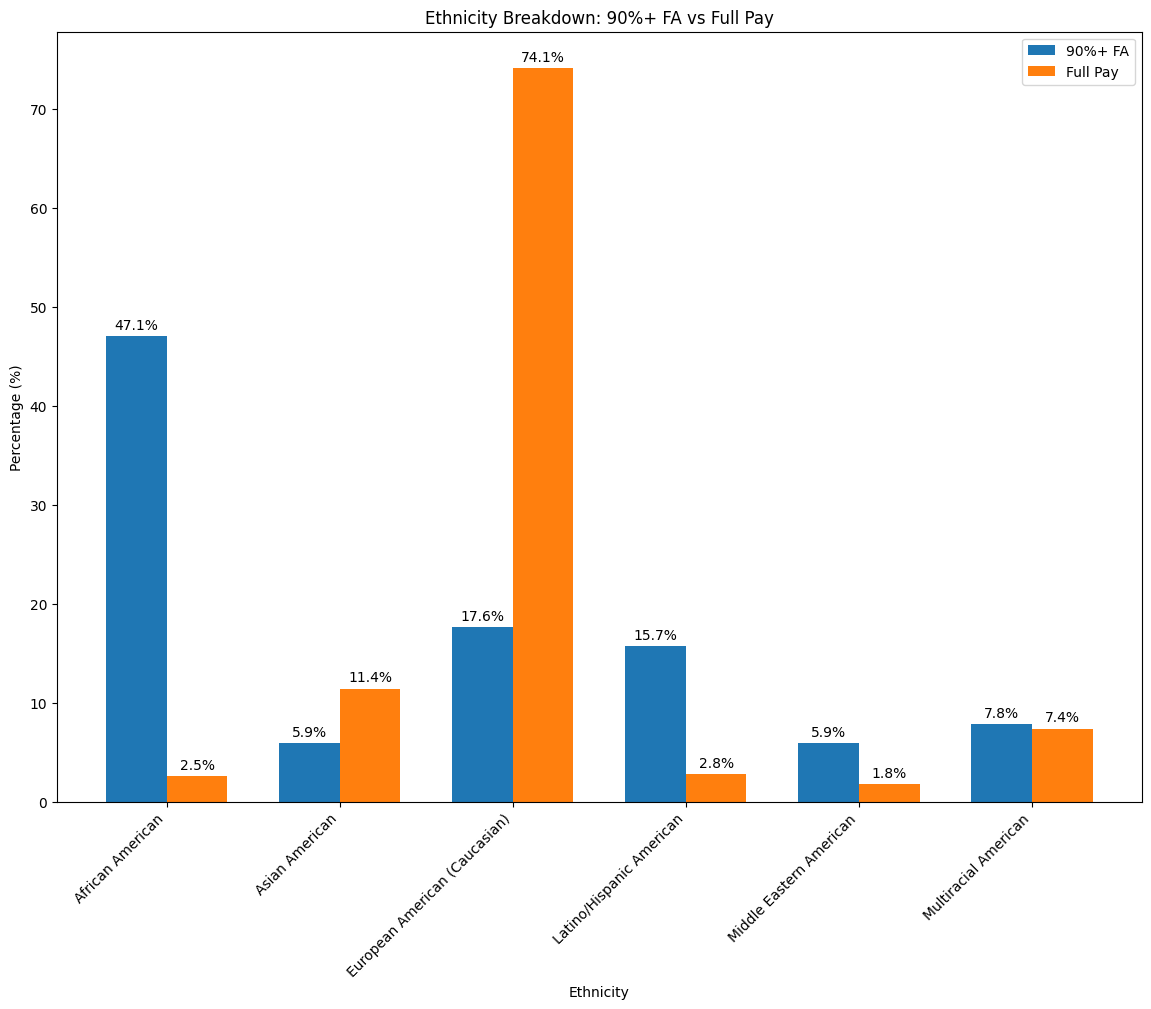

In [ ]:
#Graph
import matplotlib.pyplot as plt
import numpy as np

graph_image_path = "/content/ethnicity_comparison.png"

ethnicities = comparison_df['ethnicity']
fa_90 = comparison_df['percentage_fa_90']
full_pay = comparison_df['percentage_full_pay']

x = np.arange(len(ethnicities))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 10))


bars1 = ax.bar(x - width/2, fa_90, width, label='90%+ FA')
bars2 = ax.bar(x + width/2, full_pay, width, label='Full Pay')


ax.set_xlabel('Ethnicity')
ax.set_ylabel('Percentage (%)')
ax.set_title('Ethnicity Breakdown: 90%+ FA vs Full Pay')
ax.set_xticks(x)
ax.set_xticklabels(ethnicities, rotation=45, ha="right")
ax.legend()


def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)



plt.show()
plt.tight_layout()
plt.savefig(graph_image_path, dpi=300)
plt.close()


In [ ]:
#Report
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from PIL import Image
import os


if not os.path.exists(graph_image_path):
    raise FileNotFoundError(f"The image {graph_image_path} does not exist. Check the saving process.")


pdf_filename = "Ethnicity_Comparison_Report.pdf"
c = canvas.Canvas(pdf_filename, pagesize=letter)


c.setFont("Helvetica-Bold", 16)
c.drawString(50, 750, "Ethnicity Comparison Report")


c.setFont("Helvetica", 12)
c.drawString(50, 730, "Comparison of ethnicity breakdown between 90%+ FA and Full Pay students.")


image = Image.open(graph_image_path)
image_width, image_height = image.size


max_width = 500
max_height = 400
scale = min(max_width / image_width, max_height / image_height)
scaled_width = int(image_width * scale)
scaled_height = int(image_height * scale)


c.drawImage(graph_image_path, 50, 250, width=scaled_width, height=scaled_height)


c.setFont("Helvetica", 12)
c.drawString(50, 230, "This chart shows the percentage distribution of ethnicities for students in two groups:")
c.drawString(50, 215, "- 90%+ Financial Aid: Students receiving 90-100% of tuition covered by financial aid.")
c.drawString(50, 200, "- Full Pay: Students paying full tuition without financial aid.")


c.save()


try:
    from google.colab import files
    files.download(pdf_filename)
except ImportError:
    print(f"PDF saved as {pdf_filename}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **4) Return a list of all students who earned an A- GPA or higher**

In [ ]:

query_4 = """SELECT *
FROM College
WHERE gpa >= 10.0
"""

query_4 = pd.read_sql_query(query_4, conn)
query_4.head()



,college_id,admission_id,gpa,sat,act,matric,university_id,hook_athlete,hook_first_gen,hook_legacy
0,1,10528,11.00,1580.0,35.0,University of Southern Maine,161554,True,False,False
1,2,10532,10.95,1520.0,0.0,American International College,164447,False,False,False
2,3,16650,10.93,1550.0,0.0,Saint Elizabeth School of Nursing,152497,False,False,False
3,4,243176,10.92,1580.0,0.0,Tufts University,168148,False,False,False
4,5,12785,10.90,1570.0,0.0,Boston College,164924,True,False,False


In [ ]:
# report
pdf_filename = "Students with GPA equal or greater than A-.pdf"
c = canvas.Canvas(pdf_filename, pagesize=letter)


c.setFont("Helvetica-Bold", 16)
c.drawString(100, 750, "Students with GPA equal or greater than A-")


c.setFont("Helvetica", 12)
y_position = 730


for index, row in query_4.iterrows():
    text = f"Admission ID: {row['admission_id']} - University: {row['matric']} - GPA: {row['gpa']}"
    c.drawString(100, y_position, text)
    y_position -= 20
    if y_position < 100:
        c.showPage()
        c.setFont("Helvetica", 12)
        y_position = 750


c.save()


files.download(pdf_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **5) Return a list of all students who were recruited athletes grouped by graduation year.  Include the university name that the student ended up matriculating at and whether the student was an early admit or not.**

In [12]:
query_5 = query_recruited_athletes = """
SELECT
    Admission.grad_year,
    Students.student_id,
    Universities.institution_name AS university_name,
    CASE
        WHEN College.hook_athlete = 'True' THEN 'Yes'
        ELSE 'No'
    END AS recruited_athlete,
    CASE
        WHEN Applications.ed = 1 THEN 'Yes'
        ELSE 'No'
    END AS early_admit
FROM
    Students
INNER JOIN
    Admission
ON
    Students.admission_id = Admission.admission_id
INNER JOIN
    College
ON
    Students.college_id = College.college_id
INNER JOIN
    Universities
ON
    College.university_id = Universities.university_id
INNER JOIN
    Applications
ON
    Students.student_id = Applications.student_id
WHERE
    College.hook_athlete = 'True'
GROUP BY
    Admission.grad_year, Students.student_id, Universities.institution_name, Applications.ed;
"""

df_recruited_athletes = pd.read_sql_query(query_recruited_athletes, conn)
df_recruited_athletes.head()



df_5 = pd.read_sql_query(query_5, conn)
df_5.head()



,grad_year,student_id,university_name,recruited_athlete,early_admit
0,2019,7447,Princeton University,Yes,No
1,2019,7447,Princeton University,Yes,Yes
2,2019,7518,Southeastern College-Charleston,Yes,No
3,2019,7518,Southeastern College-Charleston,Yes,Yes
4,2019,7554,Williams College,Yes,Yes


In [ ]:
# report
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import textwrap


pdf_filename = "Recruited_Athletes_Report.pdf"


page_width, page_height = letter
left_margin = 50
right_margin = page_width - 50
line_height = 15
bottom_margin = 100


c = canvas.Canvas(pdf_filename, pagesize=letter)


c.setFont("Helvetica-Bold", 16)
c.drawString(left_margin, page_height - 50, "Recruited Athletes Report")


c.setFont("Helvetica", 12)
y_position = page_height - 70
c.drawString(left_margin, y_position, "List of recruited athletes by graduation year:")
y_position -= 20

def add_wrapped_text(c, text, y_position, left_margin, right_margin, line_height):
    """Agrega texto ajustado dentro de los márgenes del PDF."""
    wrapped_text = textwrap.wrap(text, width=90)
    for line in wrapped_text:
        c.drawString(left_margin, y_position, line)
        y_position -= line_height
        if y_position < bottom_margin:
            c.showPage()
            c.setFont("Helvetica", 12)
            y_position = page_height - 50
    return y_position


for _, row in df_recruited_athletes.iterrows():
    text = (
        f"Graduation Year: {row['grad_year']}, "
        f"Student ID: {row['student_id']}, "
        f"University: {row['university_name']}, "
        f"Recruited Athlete: {row['recruited_athlete']}, "
        f"Early Admit: {row['early_admit']}"
    )
    y_position = add_wrapped_text(c, text, y_position, left_margin, right_margin, line_height)


c.save()


try:
    from google.colab import files
    files.download(pdf_filename)
except ImportError:
    print(f"PDF saved as {pdf_filename}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **6) What percentage of each graduating class was admitted early decision? Create a bar graph of the trends by graduating class.**

In [ ]:
#Query 6
query_6 = """
SELECT
    Admission.grad_year AS graduating_year,
    COUNT(DISTINCT CASE
        WHEN Applications.ed = 1 AND Applications.admitted = 1 THEN Applications.application_id
    END) * 1.0 /
    COUNT(DISTINCT CASE
        WHEN Applications.admitted = 1 THEN Applications.application_id
    END) * 100 AS percentage_early_decision_admitted
FROM
    Admission
JOIN
    Students ON Admission.admission_id = Students.admission_id
JOIN
    Applications ON Students.student_id = Applications.student_id
GROUP BY
    Admission.grad_year
ORDER BY
    Admission.grad_year
"""

df_6 = pd.read_sql_query(query_6, conn)
df_6.head()

,graduating_year,percentage_early_decision_admitted
0,2019,22.743682
1,2020,15.272727
2,2021,18.772563
3,2022,20.370370


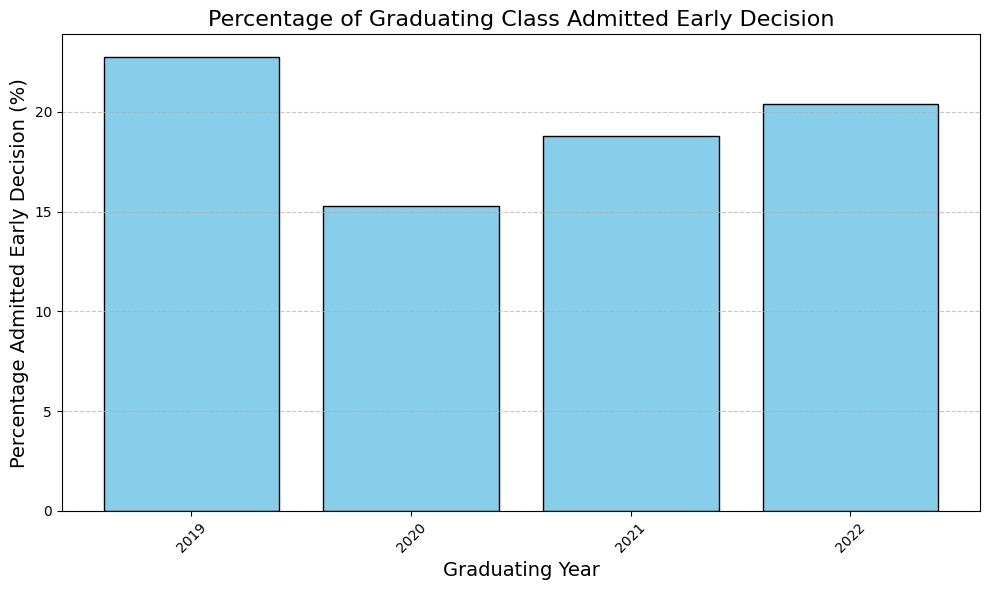

In [ ]:
# Barplot
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(df_6['graduating_year'], df_6['percentage_early_decision_admitted'], color='skyblue', edgecolor='black')
plt.title('Percentage of Graduating Class Admitted Early Decision', fontsize=16)
plt.xlabel('Graduating Year', fontsize=14)
plt.ylabel('Percentage Admitted Early Decision (%)', fontsize=14)
plt.xticks(df_6['graduating_year'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

fig.canvas.draw()
buf = fig.canvas.tostring_rgb()
width, height = fig.canvas.get_width_height()
pil_image = Image.frombytes("RGB", (width, height), buf)
plt.show()

In [15]:
#Report
pdf_filename = "Percentage_of_Graduating_Class_Admitted_Early_Decision.pdf"
c = canvas.Canvas(pdf_filename, pagesize=letter)

c.setFont("Helvetica-Bold", 16)
c.drawString(100, 750, "Percentage of Graduating Class Admitted Early Decision")


c.setFont("Helvetica", 12)
y_position = 730


for _, row in df_6.iterrows():
    text = f"Graduating Year: {int(row['graduating_year'])} - Percentage Admitted Early Decision: {row['percentage_early_decision_admitted']:.2f}%"
    c.drawString(50, y_position, text)
    y_position -= 20
    if y_position < 100:
        c.showPage()
        c.setFont("Helvetica", 12)
        y_position = 750

c.drawInlineImage(pil_image, x = 0, y = 300, width=width/1.75, height=height/1.75)

c.save()

files.download(pdf_filename)

NameError: name 'df_6' is not defined

### **7) Count the number of submitted applications per student. Create a bar graph of the distribution of the number of applications per student**


In [13]:
query_7 = """WITH temp_apps AS (
    SELECT
        DISTINCT Applications.student_id,
        COUNT(Applications.student_id) AS App_Count
    FROM Applications
    GROUP BY Applications.student_id)
SELECT DISTINCT App_Count, COUNT(App_Count) AS Num_Students
FROM temp_apps
GROUP BY App_Count;"""


df_7 = pd.read_sql_query(query_7, conn)
df_7.head()

,App_Count,Num_Students
0,1,54
1,2,8
2,3,21
3,4,35
4,5,57


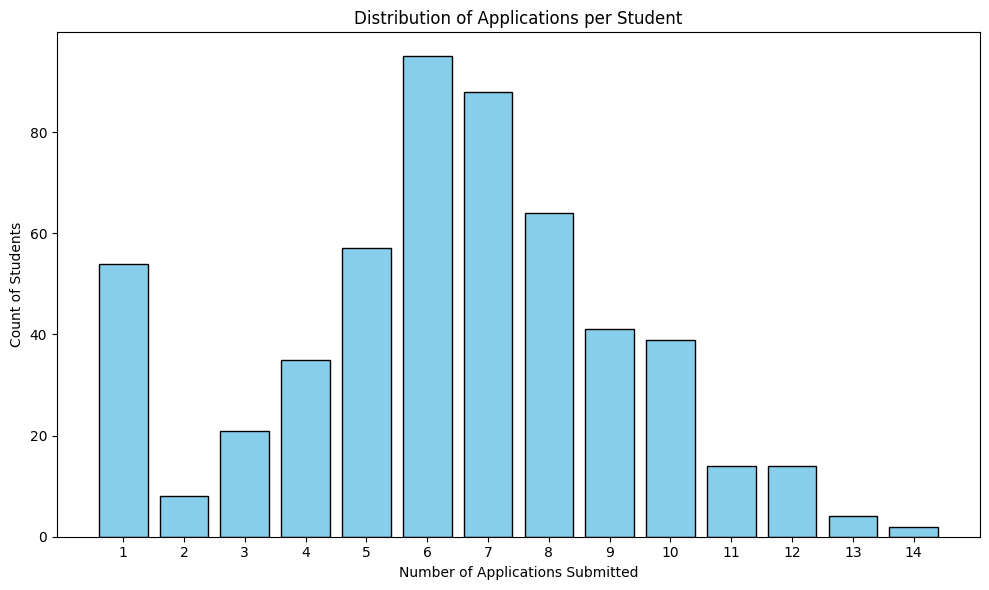

In [14]:
# plotting query 7
graph_image_path = "/content/applications_per_student.png"
plt.figure(figsize=(10, 6))
plt.bar(df_7['App_Count'], df_7['Num_Students'], color='skyblue', edgecolor='black')
plt.xlabel('Number of Applications Submitted')
plt.ylabel('Count of Students')
plt.title('Distribution of Applications per Student')
plt.xticks(df_7['App_Count'])
plt.tight_layout()
plt.savefig(graph_image_path, dpi=300)
plt.show()

In [18]:
# Report
pdf_filename = "Distribution_of_College_Applications_per_Student.pdf"
c = canvas.Canvas(pdf_filename, pagesize=letter)

c.setFont("Helvetica-Bold", 16)
c.drawString(100, 750, "Distribution of College Applications per Student")


c.setFont("Helvetica", 12)
y_position = 730


image = Image.open(graph_image_path)
image_width, image_height = image.size


max_width = 500
max_height = 400
scale = min(max_width / image_width, max_height / image_height)
scaled_width = int(image_width * scale)
scaled_height = int(image_height * scale)


c.drawImage(graph_image_path, 50, 400, width=scaled_width, height=scaled_height)

c.setFont("Helvetica", 12)
c.drawString(50, 380, "This chart shows the typical number of applications students submit.")
c.drawString(50, 365, "- Many athletes are recruited and submit only one application.")
c.drawString(50, 350, "- Most other students follow a bell curve, with the center of the curve being 6-7 applications.")

c.save()

files.download(pdf_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **8) Compare Academy X's admission rate into popular Boston Universities and compare this to each University's global admit rate**


In [ ]:
# note: popular Boston universities include Harvard University, Boston College, Tufts University, and Boston University
query_8 = """
SELECT
  Universities.institution_name,
  Universities.percent_admitted,
  COUNT(Applications.application_id) AS applications_count,
  COUNT(
    CASE WHEN Applications.admitted == '1' THEN 1
    END) AS admitted
FROM Applications
JOIN Universities ON Applications.university_id = Universities.university_id
WHERE Universities.institution_name IN ('Harvard University', 'Boston College', 'Tufts University', 'Boston University')
GROUP BY Universities.institution_name;
"""

In [ ]:
df_8 = pd.read_sql_query(query_8, conn)
df_8['school_percent_admitted']= (round((df_8['admitted']/df_8['applications_count'])*100,0))
df_8.head()

,institution_name,percent_admitted,applications_count,admitted,school_percent_admitted
0,Boston College,17,203,60,30.0
1,Boston University,14,79,17,22.0
2,Harvard University,3,238,26,11.0
3,Tufts University,10,129,27,21.0


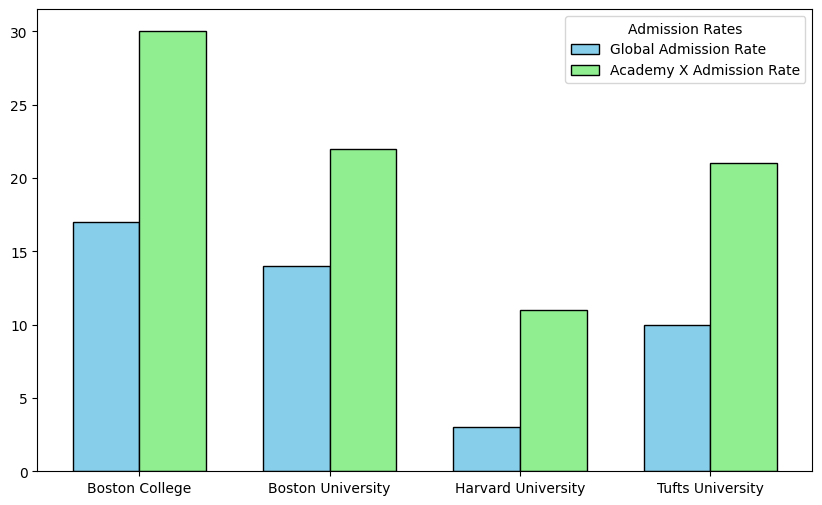

Imagen guardada en: /content/admission_chart.png


In [ ]:
#Graph
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


fig, ax = plt.subplots(figsize=(10, 6))

categories = df_8['institution_name']
bar_width = 0.35
x = np.arange(len(categories))
y1 = df_8['percent_admitted']
y2 = df_8['school_percent_admitted']

ax.bar(x - bar_width/2, y1, width=bar_width, color='skyblue', label='Global Admission Rate', edgecolor='black')
ax.bar(x + bar_width/2, y2, width=bar_width, color='lightgreen', label='Academy X Admission Rate', edgecolor='black')


ax.set_xticks(x)
ax.set_xticklabels(categories)
plt.legend(title="Admission Rates")


plt.show()


img_path = "/content/admission_chart.png"
fig.savefig(img_path)
print(f"Imagen guardada en: {img_path}")


In [ ]:
#Report
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import textwrap


pdf_filename = "Admission_Statistics_Report.pdf"
c = canvas.Canvas(pdf_filename, pagesize=letter)


left_margin = 50
right_margin = 550
text_width = right_margin - left_margin
y_position = 730


c.setFont("Helvetica-Bold", 16)
c.drawString(left_margin, 750, "Admission Statistics Report")


c.setFont("Helvetica", 12)


for _, row in df_8.iterrows():
    text = (
        f"University: {row['institution_name']} - Percent Admitted: {row['percent_admitted']}% "
        f"- Applications: {row['applications_count']} - Admitted: {row['admitted']} "
        f"- School Percent Admitted: {row['school_percent_admitted']}%"
    )


    wrapped_text = textwrap.wrap(text, width=75)


    for line in wrapped_text:
        c.drawString(left_margin, y_position, line)
        y_position -= 20
        if y_position < 300:
            c.showPage()
            c.setFont("Helvetica", 12)
            y_position = 750


c.drawInlineImage("/content/admission_chart.png", x=50, y=100, width=500, height=300)


c.save()


try:
    from google.colab import files
    files.download(pdf_filename)
except ImportError:
    print(f"PDF generado: {pdf_filename}")




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **9) Create a scatterplot of incoming GPA vs outgoing GPA**
### **a) Create a boxplot comparing outgoing GPA grouped by MS type**

In [ ]:
query_9 = """
SELECT
  AVG(Admission.incoming_gpa) AS avg_incoming_gpa,
  MAX(Admission.incoming_gpa) AS max_incoming_gpa,
  MIN(Admission.incoming_gpa) AS min_incoming_gpa,
  AVG(College.gpa) AS avg_outgoing_gpa,
  MAX(College.gpa) AS max_outgoing_gpa,
  MIN(College.gpa) AS min_outgoing_gpa,
  Sending_ms.ms_type
FROM Admission
JOIN College ON Admission.admission_id = College.admission_id
JOIN Sending_ms ON Admission.sending_ms_id = Sending_ms.sending_ms_id
GROUP BY Sending_ms.ms_type;
"""

query_9_temp = """
SELECT
  Admission.incoming_gpa,
  College.gpa AS outgoing_gpa,
  Sending_ms.ms_type
FROM Admission
JOIN College ON Admission.admission_id = College.admission_id
JOIN Sending_ms ON Admission.sending_ms_id = Sending_ms.sending_ms_id;
"""
df_9 = pd.read_sql_query(query_9_temp, conn)
df_9.head()

,incoming_gpa,outgoing_gpa,ms_type
0,9.0500,11.00,Parochial
1,9.6757,10.95,Parochial
2,10.1750,10.93,Public
3,10.3659,10.92,Public
4,9.8875,10.90,Independent


In [ ]:
mask = df_9.ms_type == 'public'
df_9.loc[mask, 'ms_type'] = 'Public'
df_9['ms_type'].unique()

array(['Parochial', 'Public', 'Independent', 'Charter', 'Home School'],
      dtype=object)

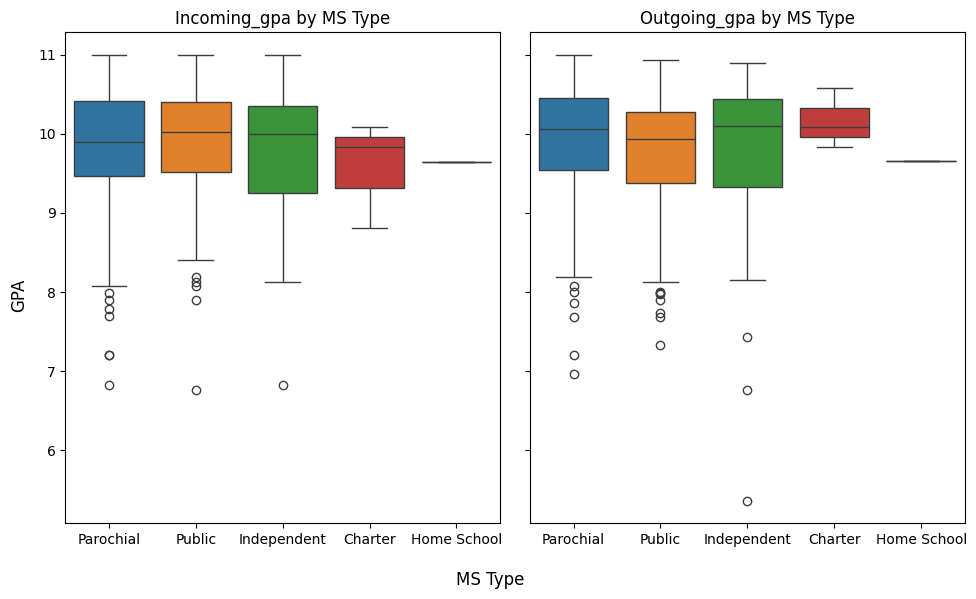

In [ ]:
# Graph
cols_to_plot = ['incoming_gpa', 'outgoing_gpa']


fig, ax = plt.subplots(figsize=(10, 6), ncols=len(cols_to_plot), sharex=True, sharey=True)
for i, col in enumerate(cols_to_plot):
    sns.boxplot(x='ms_type', y=col, data=df_9, ax=ax[i], hue = "ms_type")\
    .set(xlabel=None, ylabel=None)
    ax[i].set_title(f'{col.capitalize()} by MS Type')

fig.supxlabel('MS Type')
fig.supylabel('GPA')

plt.tight_layout()

fig.canvas.draw()
buf = fig.canvas.tostring_rgb()
width, height = fig.canvas.get_width_height()
pil_image = Image.frombytes("RGB", (width, height), buf)
plt.show()

img_path = "/content/outgoing_gpa_boxplot.png"
plt.savefig(img_path)
plt.close()

In [ ]:
# Report
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import textwrap


pdf_filename = "Outgoing_GPA_Report.pdf"
c = canvas.Canvas(pdf_filename, pagesize=letter)


left_margin = 50
right_margin = 550
text_width = right_margin - left_margin
y_position = 750


c.setFont("Helvetica-Bold", 16)
c.drawString(left_margin, y_position, "Outgoing GPA by MS Type Report")


y_position -= 30
c.setFont("Helvetica", 14)
c.drawString(left_margin, y_position, "Data Summary and Analysis")


y_position -= 30
c.setFont("Helvetica", 12)


for _, row in df_9.iterrows():
    text = (
        f"MS Type: {row['ms_type']} - Incoming GPA: {row['incoming_gpa']:.2f} - "
        f"Outgoing GPA: {row['outgoing_gpa']:.2f}"
    )


    wrapped_text = textwrap.wrap(text, width=75)


    for line in wrapped_text:
        c.drawString(left_margin, y_position, line)
        y_position -= 20
        if y_position < 150:
            c.showPage()
            c.setFont("Helvetica", 12)
            y_position = 750

c.drawInlineImage(img_path, x=50, y=100, width=500, height=300)


c.save()


try:
    from google.colab import files
    files.download(pdf_filename)
except ImportError:
    print(f"PDF generado: {pdf_filename}")





<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>